**CSCI 4341 – Big Data Analytics | Individual Assignment | Semester 2 2021/2022**

**Nur Qhaisara binti Mohd Zakzam**

**1913074**

**nurqhaisara1913074@gmail.com**

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"]= "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]= "/content/spark-3.2.1-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkConf 
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark import SparkContext
from pyspark.sql import HiveContext
from pyspark.sql import functions as F
from pyspark.sql.functions import count,col

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
spark = SparkSession\
        .builder\
        .appName("HREmployee")\
        .getOrCreate()

In [5]:
spark

In [6]:
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1656863585295'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.app.startTime', '1656863582983'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'HREmployee'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '35707'),
 ('spark.driver.host', 'b82caa19c610')]

# **Data Collection**

In [7]:
path = "data/WA_Fn-UseC_-HR-Employee-Attrition.csv"

employee = spark.read.csv(path, header=True)

# **Data Preprocessing**

In [8]:
employee.printSchema()

root
 |-- Age: string (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: string (nullable = true)
 |-- EmployeeNumber: string (nullable = true)
 |-- EnvironmentSatisfaction: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: string (nullable = true)
 |-- JobInvolvement: string (nullable = true)
 |-- JobLevel: string (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: string (nullable = true)
 |-- MonthlyRate: string (nullable = true)
 |-- NumCompaniesWorked: string (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string (nullable = tr

In [9]:
employee.describe()

DataFrame[summary: string, Age: string, Attrition: string, BusinessTravel: string, DailyRate: string, Department: string, DistanceFromHome: string, Education: string, EducationField: string, EmployeeCount: string, EmployeeNumber: string, EnvironmentSatisfaction: string, Gender: string, HourlyRate: string, JobInvolvement: string, JobLevel: string, JobRole: string, JobSatisfaction: string, MaritalStatus: string, MonthlyIncome: string, MonthlyRate: string, NumCompaniesWorked: string, Over18: string, OverTime: string, PercentSalaryHike: string, PerformanceRating: string, RelationshipSatisfaction: string, StandardHours: string, StockOptionLevel: string, TotalWorkingYears: string, TrainingTimesLastYear: string, WorkLifeBalance: string, YearsAtCompany: string, YearsInCurrentRole: string, YearsSinceLastPromotion: string, YearsWithCurrManager: string]

In [10]:
len(employee.columns), employee.columns #number of columns

(35,
 ['Age',
  'Attrition',
  'BusinessTravel',
  'DailyRate',
  'Department',
  'DistanceFromHome',
  'Education',
  'EducationField',
  'EmployeeCount',
  'EmployeeNumber',
  'EnvironmentSatisfaction',
  'Gender',
  'HourlyRate',
  'JobInvolvement',
  'JobLevel',
  'JobRole',
  'JobSatisfaction',
  'MaritalStatus',
  'MonthlyIncome',
  'MonthlyRate',
  'NumCompaniesWorked',
  'Over18',
  'OverTime',
  'PercentSalaryHike',
  'PerformanceRating',
  'RelationshipSatisfaction',
  'StandardHours',
  'StockOptionLevel',
  'TotalWorkingYears',
  'TrainingTimesLastYear',
  'WorkLifeBalance',
  'YearsAtCompany',
  'YearsInCurrentRole',
  'YearsSinceLastPromotion',
  'YearsWithCurrManager'])

In [11]:
employee.count() #number of rows

1470

In [12]:
employee.head()

Row(Age='41', Attrition='Yes', BusinessTravel='Travel_Rarely', DailyRate='1102', Department='Sales', DistanceFromHome='1', Education='2', EducationField='Life Sciences', EmployeeCount='1', EmployeeNumber='1', EnvironmentSatisfaction='2', Gender='Female', HourlyRate='94', JobInvolvement='3', JobLevel='2', JobRole='Sales Executive', JobSatisfaction='4', MaritalStatus='Single', MonthlyIncome='5993', MonthlyRate='19479', NumCompaniesWorked='8', Over18='Y', OverTime='Yes', PercentSalaryHike='11', PerformanceRating='3', RelationshipSatisfaction='1', StandardHours='80', StockOptionLevel='0', TotalWorkingYears='8', TrainingTimesLastYear='0', WorkLifeBalance='1', YearsAtCompany='6', YearsInCurrentRole='4', YearsSinceLastPromotion='0', YearsWithCurrManager='5')

In [13]:
employee.show(n=3)

+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalanc

In [14]:
employee.describe().show(truncate=False)

+-------+------------------+---------+--------------+------------------+---------------+----------------+------------------+----------------+-------------+-----------------+-----------------------+------+------------------+------------------+------------------+-------------------------+------------------+-------------+-----------------+------------------+------------------+------+--------+------------------+-------------------+------------------------+-------------+------------------+------------------+---------------------+------------------+------------------+------------------+-----------------------+--------------------+
|summary|Age               |Attrition|BusinessTravel|DailyRate         |Department     |DistanceFromHome|Education         |EducationField  |EmployeeCount|EmployeeNumber   |EnvironmentSatisfaction|Gender|HourlyRate        |JobInvolvement    |JobLevel          |JobRole                  |JobSatisfaction   |MaritalStatus|MonthlyIncome    |MonthlyRate       |NumCompani

In [15]:
employee2 = employee.withColumn("Attrition", F.when(employee.Attrition == "Yes", 1).otherwise(0)).withColumn("Gender", F.when(employee.Gender == "Male", 1).otherwise(0))

In [16]:
employee2.describe().show(truncate=False)

+-------+------------------+-------------------+--------------+------------------+---------------+----------------+------------------+----------------+-------------+-----------------+-----------------------+------------------+------------------+------------------+------------------+-------------------------+------------------+-------------+-----------------+------------------+------------------+------+--------+------------------+-------------------+------------------------+-------------+------------------+------------------+---------------------+------------------+------------------+------------------+-----------------------+--------------------+
|summary|Age               |Attrition          |BusinessTravel|DailyRate         |Department     |DistanceFromHome|Education         |EducationField  |EmployeeCount|EmployeeNumber   |EnvironmentSatisfaction|Gender            |HourlyRate        |JobInvolvement    |JobLevel          |JobRole                  |JobSatisfaction   |MaritalStatus|Mon

# **Data Cleaning**

In [17]:
employee = employee.dropna()

In [18]:
employee = employee.dropDuplicates()

In [19]:
employee.count()

1470

# **Exploratory Data Analysis**

**Data Science Question 1**

In [20]:
attritionGenderPlot = employee.filter(employee.Attrition == "Yes").groupby(employee.Gender).count().orderBy(employee.Gender.cast("integer"))

In [21]:
attritionGenderPlot.show() 

+------+-----+
|Gender|count|
+------+-----+
|Female|   87|
|  Male|  150|
+------+-----+



In [22]:
x = attritionGenderPlot.toPandas()["Gender"].values.tolist()
y = attritionGenderPlot.toPandas()["count"].values.tolist()

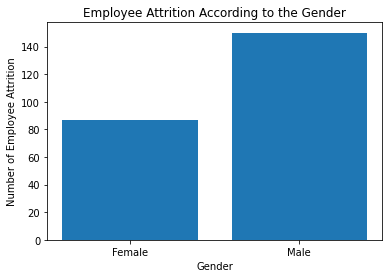

In [23]:
plt.bar(x,y)
plt.title("Employee Attrition According to the Gender")
plt.xlabel("Gender")
plt.ylabel("Number of Employee Attrition")
plt.show()

Based on the bar graph above, male employee attrition is higher than female employee attrition. There are 150 male employees and 87 female employees applying for attrition. Male employee attrition may be higher than female because of working styles, workload or perhaps in need of new environment in working space.

**Data Science Question 2**

In [24]:
employee.groupBy("JobRole").count().show(truncate=False)

+-------------------------+-----+
|JobRole                  |count|
+-------------------------+-----+
|Sales Executive          |326  |
|Manufacturing Director   |145  |
|Laboratory Technician    |259  |
|Sales Representative     |83   |
|Healthcare Representative|131  |
|Research Scientist       |292  |
|Manager                  |102  |
|Research Director        |80   |
|Human Resources          |52   |
+-------------------------+-----+



In [25]:
employee.groupBy("JobRole").agg(count("Attrition")).where(employee.JobRole == "Sales Representative").show()

+--------------------+----------------+
|             JobRole|count(Attrition)|
+--------------------+----------------+
|Sales Representative|              83|
+--------------------+----------------+



In [26]:
employee.groupBy("Attrition").agg(count("JobRole")).where(employee.Attrition == "Yes").show()

+---------+--------------+
|Attrition|count(JobRole)|
+---------+--------------+
|      Yes|           237|
+---------+--------------+



In [27]:
attrition_JobRole_Plot = employee.filter(employee.Attrition == "Yes").groupby(employee.JobRole).count().orderBy(employee.JobRole.cast("integer"))

In [28]:
attrition_JobRole_Plot.show(truncate=False) 

+-------------------------+-----+
|JobRole                  |count|
+-------------------------+-----+
|Sales Executive          |57   |
|Manufacturing Director   |10   |
|Laboratory Technician    |62   |
|Sales Representative     |33   |
|Healthcare Representative|9    |
|Research Scientist       |47   |
|Manager                  |5    |
|Research Director        |2    |
|Human Resources          |12   |
+-------------------------+-----+



In [29]:
x = attrition_JobRole_Plot.toPandas()["JobRole"].values.tolist()
y = attrition_JobRole_Plot.toPandas()["count"].values.tolist()

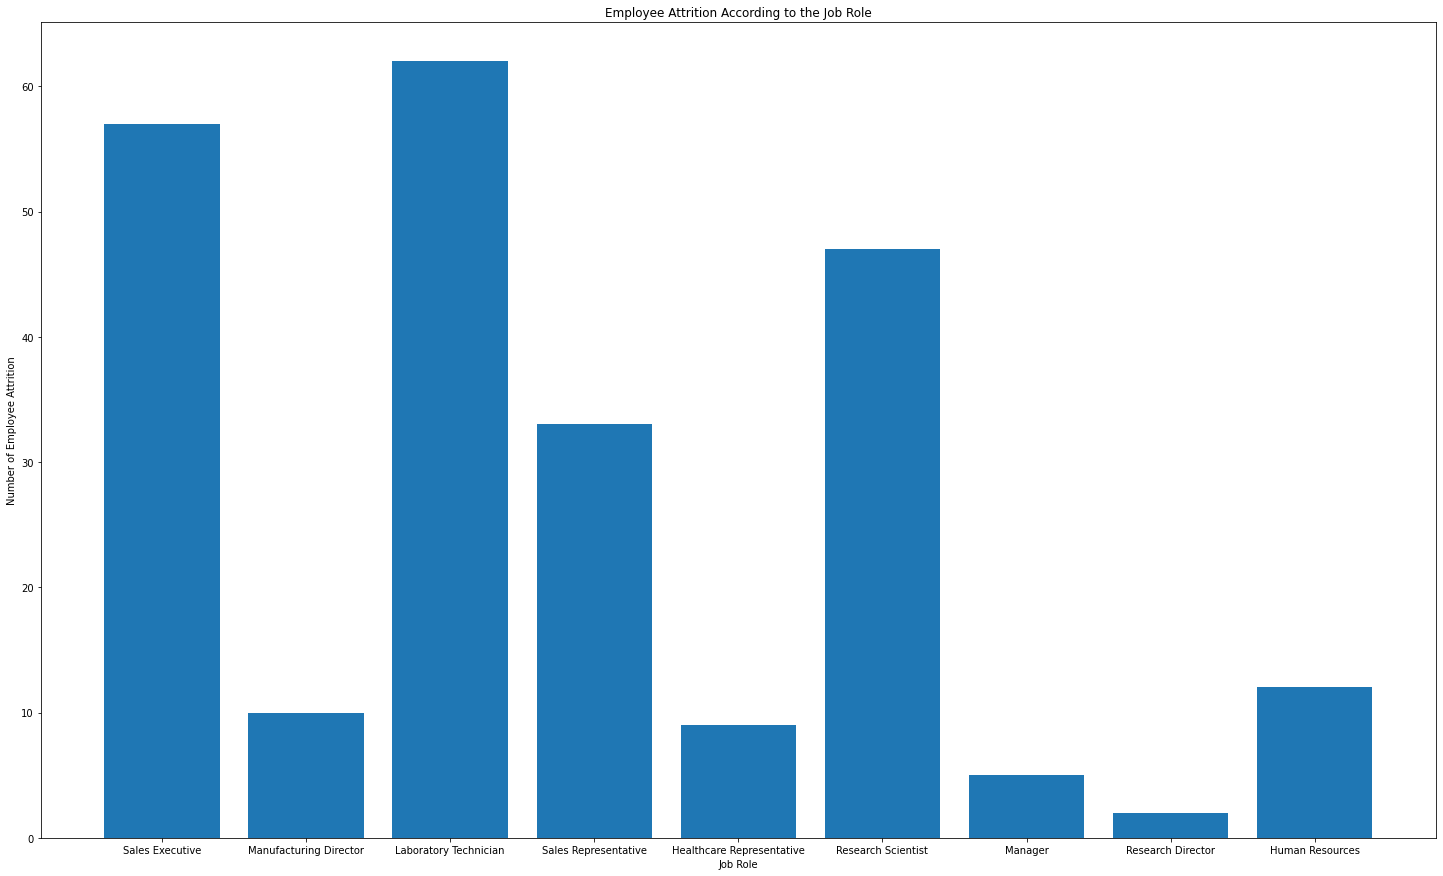

In [30]:
fig = plt.figure(figsize = (25, 15))
plt.bar(x,y)
plt.title("Employee Attrition According to the Job Role")
plt.xlabel("Job Role")
plt.ylabel("Number of Employee Attrition")
plt.show()

Laboratory Technician is the highest job role that influence on employee attrition which at 62. Sales Executive comes to the second at 33 and the third job role influence on employee attrition is Research Scientist at 47. The lowest job role that influences on employee attrition is Research Director. Laboratory Technician needs to deal with conducting multiple experiments, research and testing on the experiments. Hence, it required a lot of tasks to deal with. Perhaps, they need a lot of experience in order to do a better job. As a consequence, this job roles is the highest that contributes in influencing the employee attrition.

**Data Science Question 3**

In [31]:
employee.groupBy("RelationshipSatisfaction").count().show(truncate=False)

+------------------------+-----+
|RelationshipSatisfaction|count|
+------------------------+-----+
|3                       |459  |
|1                       |276  |
|4                       |432  |
|2                       |303  |
+------------------------+-----+



In [32]:
employee.groupBy("EnvironmentSatisfaction").count().show(truncate=False)

+-----------------------+-----+
|EnvironmentSatisfaction|count|
+-----------------------+-----+
|3                      |453  |
|1                      |284  |
|4                      |446  |
|2                      |287  |
+-----------------------+-----+



In [33]:
employee = employee.withColumn("RelationshipSatisfaction", employee["RelationshipSatisfaction"].cast(IntegerType()))
employee = employee.withColumn("EnvironmentSatisfaction", employee["EnvironmentSatisfaction"].cast(IntegerType()))

In [34]:
employee.stat.corr("RelationshipSatisfaction", "EnvironmentSatisfaction")

0.007665383541074482

The RelationshipSatisfaction does not affect the EnvironmentSatisfaction that much since the correlation between them is just 0.007665383541074482. The correlation is slightly higher than 0 and far from 1.0. This shows that event though the RelationshipSatisfaction is low, the EnvironmentSatisfaction may be very high.

**Data Science Question 4**

In [35]:
employee.groupBy("JobSatisfaction").count().show(truncate=False)

+---------------+-----+
|JobSatisfaction|count|
+---------------+-----+
|3              |442  |
|1              |289  |
|4              |459  |
|2              |280  |
+---------------+-----+



In [36]:
employee.groupBy("PerformanceRating").count().show(truncate=False)

+-----------------+-----+
|PerformanceRating|count|
+-----------------+-----+
|3                |1244 |
|4                |226  |
+-----------------+-----+



In [37]:
employee = employee.withColumn("JobSatisfaction", employee["JobSatisfaction"].cast(IntegerType()))
employee = employee.withColumn("PerformanceRating", employee["PerformanceRating"].cast(IntegerType()))

In [38]:
employee.stat.corr("JobSatisfaction", "PerformanceRating")

0.0022971970637806166

The JobSatisfaction does not affect the PerformanceRating that much since the correlation between them is just 0.0022971970637806166. The correlation is slightly higher than 0 and far from 1.0. It shows that it does not mean that if employees have a very high JobSatisfaction, they will have an outstanding PerformanceRating and vice versa.

**Data Science Question 5**

In [39]:
over40 = employee.groupBy("Age").agg(count("OverTime").alias("OverTime")).filter(employee.Age >= 40).show() 

+---+--------+
|Age|OverTime|
+---+--------+
| 51|      19|
| 54|      18|
| 42|      46|
| 59|      10|
| 52|      18|
| 47|      24|
| 43|      32|
| 46|      33|
| 60|       5|
| 41|      40|
| 55|      22|
| 40|      57|
| 44|      33|
| 53|      19|
| 58|      14|
| 48|      19|
| 56|      14|
| 49|      24|
| 50|      30|
| 45|      41|
+---+--------+
only showing top 20 rows



In [40]:
below40 = employee.groupBy("Age").agg(count("OverTime").alias("OverTime")).filter(employee.Age < 40).show() 

+---+--------+
|Age|OverTime|
+---+--------+
| 29|      68|
| 30|      60|
| 34|      77|
| 28|      48|
| 22|      16|
| 35|      78|
| 31|      69|
| 18|       8|
| 27|      48|
| 26|      39|
| 19|       9|
| 23|      14|
| 38|      58|
| 25|      26|
| 33|      58|
| 24|      26|
| 32|      61|
| 20|      11|
| 36|      69|
| 37|      50|
+---+--------+
only showing top 20 rows



Based on the findings, it shows the number of employees who are above 40 years old while and the number of employees who are below 40 years old that prefer and not prefer for attrition.

**Data Science Question 6**

In [41]:
employee = employee.withColumn("TotalWorkingYears", employee["TotalWorkingYears"].cast(IntegerType()))
employee = employee.withColumn("PercentSalaryHike", employee["PercentSalaryHike"].cast(IntegerType()))

In [42]:
employee.stat.corr("TotalWorkingYears", "PercentSalaryHike")

-0.020608487617691393

In [43]:
workYear_percentSal = employee.groupBy("TotalWorkingYears").sum("PercentSalaryHike")

In [44]:
x = workYear_percentSal.toPandas()["TotalWorkingYears"].values.tolist()
y = workYear_percentSal.toPandas()["sum(PercentSalaryHike)"].values.tolist()

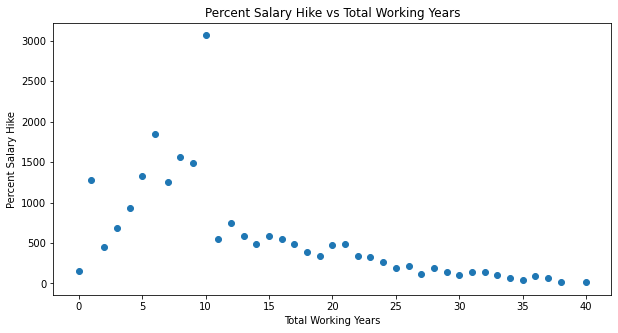

In [45]:
fig = plt.figure(figsize = (10, 5))
plt.scatter(x,y)
plt.title("Percent Salary Hike vs Total Working Years")
plt.xlabel("Total Working Years")
plt.ylabel("Percent Salary Hike")
plt.show()

Based on the scattering of total working years to the percent salary hike, as the total working years increase, the percent salary hike decrease. This may relate to job scope that becoming smaller as it will be more specific tasks.

**Data Science Question 7**

In [46]:
employee.select(F.collect_set("JobRole")).show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|collect_set(JobRole)                                                                                                                                                              |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[Human Resources, Research Director, Healthcare Representative, Manufacturing Director, Sales Executive, Laboratory Technician, Manager, Sales Representative, Research Scientist]|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+



In [47]:
employee.describe("JobRole").show(truncate=False)

+-------+-------------------------+
|summary|JobRole                  |
+-------+-------------------------+
|count  |1470                     |
|mean   |null                     |
|stddev |null                     |
|min    |Healthcare Representative|
|max    |Sales Representative     |
+-------+-------------------------+



In [48]:
employee.select(["OverTime", "JobRole", "JobLevel"]).where(employee.OverTime=="Yes").collect()

[Row(OverTime='Yes', JobRole='Laboratory Technician', JobLevel='1'),
 Row(OverTime='Yes', JobRole='Research Director', JobLevel='4'),
 Row(OverTime='Yes', JobRole='Manufacturing Director', JobLevel='4'),
 Row(OverTime='Yes', JobRole='Research Scientist', JobLevel='2'),
 Row(OverTime='Yes', JobRole='Manufacturing Director', JobLevel='2'),
 Row(OverTime='Yes', JobRole='Manager', JobLevel='5'),
 Row(OverTime='Yes', JobRole='Sales Executive', JobLevel='2'),
 Row(OverTime='Yes', JobRole='Sales Executive', JobLevel='3'),
 Row(OverTime='Yes', JobRole='Manufacturing Director', JobLevel='2'),
 Row(OverTime='Yes', JobRole='Research Scientist', JobLevel='1'),
 Row(OverTime='Yes', JobRole='Sales Executive', JobLevel='2'),
 Row(OverTime='Yes', JobRole='Research Scientist', JobLevel='1'),
 Row(OverTime='Yes', JobRole='Sales Executive', JobLevel='2'),
 Row(OverTime='Yes', JobRole='Human Resources', JobLevel='3'),
 Row(OverTime='Yes', JobRole='Sales Executive', JobLevel='3'),
 Row(OverTime='Yes', JobR

In [49]:
employee.select(["OverTime", "JobRole", "JobLevel"]).where(employee.OverTime=="Yes").where(employee.JobRole=="Sales Representative").collect()

[Row(OverTime='Yes', JobRole='Sales Representative', JobLevel='1'),
 Row(OverTime='Yes', JobRole='Sales Representative', JobLevel='1'),
 Row(OverTime='Yes', JobRole='Sales Representative', JobLevel='1'),
 Row(OverTime='Yes', JobRole='Sales Representative', JobLevel='1'),
 Row(OverTime='Yes', JobRole='Sales Representative', JobLevel='1'),
 Row(OverTime='Yes', JobRole='Sales Representative', JobLevel='1'),
 Row(OverTime='Yes', JobRole='Sales Representative', JobLevel='1'),
 Row(OverTime='Yes', JobRole='Sales Representative', JobLevel='1'),
 Row(OverTime='Yes', JobRole='Sales Representative', JobLevel='1'),
 Row(OverTime='Yes', JobRole='Sales Representative', JobLevel='1'),
 Row(OverTime='Yes', JobRole='Sales Representative', JobLevel='1'),
 Row(OverTime='Yes', JobRole='Sales Representative', JobLevel='1'),
 Row(OverTime='Yes', JobRole='Sales Representative', JobLevel='1'),
 Row(OverTime='Yes', JobRole='Sales Representative', JobLevel='1'),
 Row(OverTime='Yes', JobRole='Sales Representati

In [50]:
employee_JR_max = employee.select(["OverTime", "JobRole", "JobLevel"]).where(employee.OverTime=="Yes").where(employee.JobRole=="Sales Representative").collect()

In [51]:
print(len(employee_JR_max))

24


In [52]:
employee.select(["OverTime", "JobRole", "JobLevel"]).where(employee.OverTime=="Yes").where(employee.JobRole=="Healthcare Representative").collect()

[Row(OverTime='Yes', JobRole='Healthcare Representative', JobLevel='2'),
 Row(OverTime='Yes', JobRole='Healthcare Representative', JobLevel='4'),
 Row(OverTime='Yes', JobRole='Healthcare Representative', JobLevel='4'),
 Row(OverTime='Yes', JobRole='Healthcare Representative', JobLevel='3'),
 Row(OverTime='Yes', JobRole='Healthcare Representative', JobLevel='2'),
 Row(OverTime='Yes', JobRole='Healthcare Representative', JobLevel='2'),
 Row(OverTime='Yes', JobRole='Healthcare Representative', JobLevel='3'),
 Row(OverTime='Yes', JobRole='Healthcare Representative', JobLevel='2'),
 Row(OverTime='Yes', JobRole='Healthcare Representative', JobLevel='2'),
 Row(OverTime='Yes', JobRole='Healthcare Representative', JobLevel='2'),
 Row(OverTime='Yes', JobRole='Healthcare Representative', JobLevel='3'),
 Row(OverTime='Yes', JobRole='Healthcare Representative', JobLevel='3'),
 Row(OverTime='Yes', JobRole='Healthcare Representative', JobLevel='4'),
 Row(OverTime='Yes', JobRole='Healthcare Representa

In [53]:
employee_JR_min = employee.select(["OverTime", "JobRole", "JobLevel"]).where(employee.OverTime=="Yes").where(employee.JobRole=="Healthcare Representative").collect()

In [54]:
print(len(employee_JR_min))

37


Based on the findings, ‘Healthcare Representative’ for JobRole is the highest to choose OverTime not including the JobLevel. While the lowest is ‘Sales Representative’. It can be said that OverTime does not influence by JobLevel and JobRole.

**Data Science Question 8**

In [55]:
employee.select(["YearsAtCompany", "YearsInCurrentRole", "Attrition"]).where(employee.Attrition=="Yes").collect()

[Row(YearsAtCompany='5', YearsInCurrentRole='4', Attrition='Yes'),
 Row(YearsAtCompany='1', YearsInCurrentRole='0', Attrition='Yes'),
 Row(YearsAtCompany='1', YearsInCurrentRole='0', Attrition='Yes'),
 Row(YearsAtCompany='20', YearsInCurrentRole='6', Attrition='Yes'),
 Row(YearsAtCompany='10', YearsInCurrentRole='3', Attrition='Yes'),
 Row(YearsAtCompany='3', YearsInCurrentRole='2', Attrition='Yes'),
 Row(YearsAtCompany='1', YearsInCurrentRole='0', Attrition='Yes'),
 Row(YearsAtCompany='1', YearsInCurrentRole='0', Attrition='Yes'),
 Row(YearsAtCompany='2', YearsInCurrentRole='2', Attrition='Yes'),
 Row(YearsAtCompany='3', YearsInCurrentRole='2', Attrition='Yes'),
 Row(YearsAtCompany='1', YearsInCurrentRole='0', Attrition='Yes'),
 Row(YearsAtCompany='1', YearsInCurrentRole='0', Attrition='Yes'),
 Row(YearsAtCompany='3', YearsInCurrentRole='2', Attrition='Yes'),
 Row(YearsAtCompany='7', YearsInCurrentRole='7', Attrition='Yes'),
 Row(YearsAtCompany='7', YearsInCurrentRole='7', Attrition='

In [56]:
yearsCompany_Plot = employee.filter(employee.Attrition == "Yes").groupby(employee.YearsAtCompany).count().orderBy(employee.YearsAtCompany.cast("integer"))

In [57]:
yearsCompany_Plot.show()

+--------------+-----+
|YearsAtCompany|count|
+--------------+-----+
|             0|   16|
|             1|   59|
|             2|   27|
|             3|   20|
|             4|   19|
|             5|   21|
|             6|    9|
|             7|   11|
|             8|    9|
|             9|    8|
|            10|   18|
|            11|    2|
|            13|    2|
|            14|    2|
|            15|    1|
|            16|    1|
|            17|    1|
|            18|    1|
|            19|    1|
|            20|    1|
+--------------+-----+
only showing top 20 rows



In [58]:
x = yearsCompany_Plot.toPandas()["YearsAtCompany"].values.tolist()
y = yearsCompany_Plot.toPandas()["count"].values.tolist()

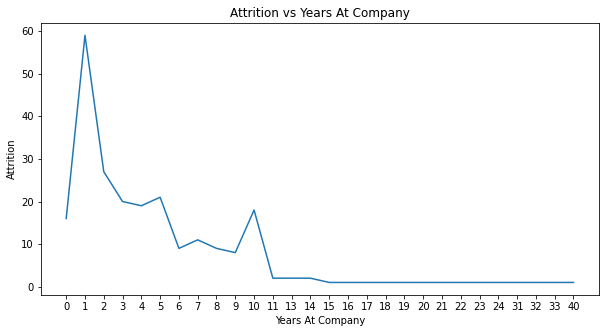

In [59]:
fig = plt.figure(figsize = (10, 5))
plt.plot(x,y)
plt.title("Attrition vs Years At Company")
plt.xlabel("Years At Company")
plt.ylabel("Attrition")
plt.show()

Graph shows that 0 year in current role contributes the highest in attrition. Perhaps this may cause by job promotion or change department than a year.

In [60]:
yearsCurrentRole_Plot = employee.filter(employee.Attrition == "Yes").groupby(employee.YearsInCurrentRole).count().orderBy(employee.YearsInCurrentRole.cast("integer"))

In [61]:
yearsCurrentRole_Plot.show()

+------------------+-----+
|YearsInCurrentRole|count|
+------------------+-----+
|                 0|   73|
|                 1|   11|
|                 2|   68|
|                 3|   16|
|                 4|   15|
|                 5|    1|
|                 6|    2|
|                 7|   31|
|                 8|    7|
|                 9|    6|
|                10|    2|
|                12|    1|
|                13|    1|
|                14|    1|
|                15|    2|
+------------------+-----+



In [62]:
x = yearsCurrentRole_Plot.toPandas()["YearsInCurrentRole"].values.tolist()
y = yearsCurrentRole_Plot.toPandas()["count"].values.tolist()

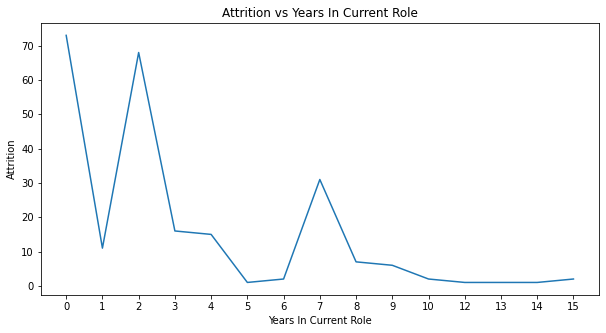

In [63]:
fig = plt.figure(figsize = (10, 5))
plt.plot(x,y)
plt.title("Attrition vs Years In Current Role")
plt.xlabel("Years In Current Role")
plt.ylabel("Attrition")
plt.show()

Graph shows that 1 year at company contributes the highest in attrition. This may happen due to job offer from other company after 1 year.

**References**
1. GeeksforGeeks. (2021, December 19). GroupBy and filter data in PySpark. Retrieved July 2, 2022, from https://www.geeksforgeeks.org/groupby-and-filter-data-in-pyspark/?ref=lbp

2. How to calculate correlation in PySpark -. (2022, May 6). ProjectPro. Retrieved July 2, 2022, from https://www.projectpro.io/recipes/calculate-correlation-pyspark